# Resolution Refinement for Enlarged Scale Images Using GANs

In [1]:
#starting to build GANs network
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
images=np.load('data.npy')
resized8=np.load('array8.npy')
%matplotlib inline

In [2]:
print("Training set size:\t",len(images))

Training set size:	 50000


In [3]:
images=images[:200]
resized8=resized8[:200]
print(len(images))

200


In [15]:
import tensorflow.contrib.layers as lays
def generator(input,reuse=None):
    with tf.variable_scope('gen',reuse=reuse):
        net = lays.conv2d_transpose(input,16, [5, 5], stride=2, padding='SAME')
        net = lays.conv2d_transpose(net,32, [5, 5], stride=2, padding='SAME')
        net = lays.conv2d_transpose(net, 3, [5, 5], stride=1, padding='SAME', activation_fn=tf.nn.tanh)
        return net

In [16]:
def discriminator(input,reuse=True):
    with tf.variable_scope('dis',reuse=reuse):
        net = lays.conv2d(input, 32, [5, 5], stride=2, padding='SAME',activation_fn=tf.nn.relu) #16 x16 x 32
        net = lays.conv2d(net, 16, [5, 5], stride=2, padding='SAME',activation_fn=tf.nn.relu) # 8 x 8 x 16
        net = lays.conv2d(net, 8, [5, 5], stride=4, padding='SAME',activation_fn=tf.nn.relu) #--> 2 x 2 x 8
        dim = int(np.prod(net.get_shape()[1:]))
        fc1 = tf.reshape(net, shape=[-1, dim], name='fc1')
        w2 = tf.get_variable('w2', shape=[fc1.shape[-1], 1], dtype=tf.float32,initializer=tf.truncated_normal_initializer(stddev=0.02))
        b2 = tf.get_variable('b2', shape=[1], dtype=tf.float32,initializer=tf.constant_initializer(0.0))
        logits = tf.add(tf.matmul(fc1, w2), b2, name='logits')
        Dis_out = tf.nn.sigmoid(logits)
        return logits

In [17]:
tf.reset_default_graph()
real_images=tf.placeholder(tf.float32, (None,32, 32, 3))
inputs_= tf.placeholder(tf.float32, (None,8, 8, 3))
G=generator(inputs_)
D_real=discriminator(real_images,reuse=None)
D_fake=discriminator(G,reuse=True)

In [18]:
def loss_func(logits_in,labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))
D_loss=loss_func(D_real,tf.ones_like(D_real)) #Smoothing for generalization
D_fake_loss=loss_func(D_fake,tf.zeros_like(D_real))
#D_loss=D_loss+D_fake_loss
G_loss= loss_func(D_fake,tf.ones_like(D_fake))

#D_loss=tf.reduce_mean(D_fake)-tf.reduce_mean(D_real)
#G_loss=-tf.reduce_mean(D_fake)
S_loss = tf.reduce_mean((G-real_images)**2)

==>>*Due to PC restriction for Training large number of the data,and it takes many times for training, here I run the training iteration only for 200 sample images, and 100 epochs*

In [20]:
lr=0.0005 #0.0002

#Do this when multiple networks interact with each other
tvars=tf.trainable_variables()  #returns all variables created(the two variable scopes) and makes trainable true
d_vars=[var for var in tvars if 'dis' in var.name]
g_vars=[var for var in tvars if 'gen' in var.name]
GENLOSS=G_loss+S_loss
D_trainer=tf.train.AdamOptimizer(lr).minimize(D_loss,var_list=d_vars)
G_trainer=tf.train.AdamOptimizer(lr).minimize(GENLOSS,var_list=g_vars) #0.001*g_loss+d_loss
#G_trainer=tf.train.AdamOptimizer(lr).minimize((0.001*G_loss+D_loss),var_list=g_vars)
batch_size=20
epochs=100
h=len(images)
init=tf.global_variables_initializer()

In [21]:
samples=[] #generator examples
Daverageloss=[]
Gaverageloss=[]
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(epochs):
        num_batches=h//batch_size
        print('epoch ',epoch)
        DLOSS=[]
        GLOSS=[]
        
        for i in range(num_batches):
            #m=i*batch_size
            batch_images=images[i*batch_size : (i+1)*batch_size].reshape(batch_size,32,32,3)
            batch_z=resized8[i*batch_size : (i+1)*batch_size].reshape(batch_size,8,8,3)
            Go=sess.run(generator(inputs_,reuse=True),feed_dict={inputs_:batch_z})
           # _=sess.run(D_trainer,feed_dict={real_images:batch_images,inputs_:batch_z})
           # _=sess.run(G_trainer,feed_dict={inputs_:batch_z})
            Dloss, _ = sess.run([D_loss, D_trainer], feed_dict={real_images:batch_images,G:Go})
            for dd in range(3): 
                Genloss, _ = sess.run([GENLOSS, G_trainer], feed_dict={inputs_:batch_z,real_images:batch_images})
            #Genloss, _ = sess.run([G_loss, G_trainer], feed_dict={inputs_:batch_z,real_images:batch_images})
            DLOSS.append(Dloss)
            GLOSS.append(Genloss)
            if epoch==epochs-1:
                samples.append(Go)
            #Genloss, _ = sess.run([g_loss, train_Gen], feed_dict={Sr:G,Hr:batch_images})
            print('epoch {} batch number {}   discrim batch loss: {} Gen batch loss: {}'.format(epoch,i,Dloss,Genloss))
        MeanDloss=np.mean(DLOSS)
        MeanGlos=np.mean(GLOSS)
        Daverageloss.append(np.mean(DLOSS))
        Gaverageloss.append(MeanGlos)
        print(' Average discrim loss: {} Average Gen loss: {} '.format(MeanDloss,MeanGlos))
       
     

epoch  0
epoch 0 batch number 0   discrim batch loss: 0.6940542459487915 Gen batch loss: 0.9230093359947205
epoch 0 batch number 1   discrim batch loss: 0.6916289925575256 Gen batch loss: 0.8971405029296875
epoch 0 batch number 2   discrim batch loss: 0.6888983249664307 Gen batch loss: 0.8807896375656128
epoch 0 batch number 3   discrim batch loss: 0.6862394213676453 Gen batch loss: 0.8197794556617737
epoch 0 batch number 4   discrim batch loss: 0.6834044456481934 Gen batch loss: 0.7591968774795532
epoch 0 batch number 5   discrim batch loss: 0.6772120594978333 Gen batch loss: 0.7463808655738831
epoch 0 batch number 6   discrim batch loss: 0.6714571118354797 Gen batch loss: 0.7182450890541077
epoch 0 batch number 7   discrim batch loss: 0.6660560369491577 Gen batch loss: 0.7125383615493774
epoch 0 batch number 8   discrim batch loss: 0.6619185209274292 Gen batch loss: 0.7175264358520508
epoch 0 batch number 9   discrim batch loss: 0.6474173665046692 Gen batch loss: 0.6831578016281128
 

epoch 7 batch number 4   discrim batch loss: 3.6470160011958797e-06 Gen batch loss: 0.017326118424534798
epoch 7 batch number 5   discrim batch loss: 2.619195811348618e-07 Gen batch loss: 0.018963215872645378
epoch 7 batch number 6   discrim batch loss: 4.2689589463407174e-05 Gen batch loss: 0.014972579665482044
epoch 7 batch number 7   discrim batch loss: 2.9797269007758587e-07 Gen batch loss: 0.013448392041027546
epoch 7 batch number 8   discrim batch loss: 2.81694174191216e-05 Gen batch loss: 0.01600481942296028
epoch 7 batch number 9   discrim batch loss: 5.859663360752165e-06 Gen batch loss: 0.01338132657110691
 Average discrim loss: 8.987716682895552e-06 Average Gen loss: 0.01686101034283638 
epoch  8
epoch 8 batch number 0   discrim batch loss: 4.288216587156057e-06 Gen batch loss: 0.018356217071413994
epoch 8 batch number 1   discrim batch loss: 1.572068299537932e-06 Gen batch loss: 0.01803971640765667
epoch 8 batch number 2   discrim batch loss: 6.679474608972669e-07 Gen batch

epoch 14 batch number 6   discrim batch loss: 2.895437864935957e-05 Gen batch loss: 0.011864684522151947
epoch 14 batch number 7   discrim batch loss: 1.485943528223288e-07 Gen batch loss: 0.010490838438272476
epoch 14 batch number 8   discrim batch loss: 1.8719638319453225e-05 Gen batch loss: 0.012993121519684792
epoch 14 batch number 9   discrim batch loss: 3.596594297050615e-06 Gen batch loss: 0.010272704996168613
 Average discrim loss: 5.808665264339652e-06 Average Gen loss: 0.012914083898067474 
epoch  15
epoch 15 batch number 0   discrim batch loss: 2.5798406113608507e-06 Gen batch loss: 0.013812393881380558
epoch 15 batch number 1   discrim batch loss: 8.657299872538715e-07 Gen batch loss: 0.013584615662693977
epoch 15 batch number 2   discrim batch loss: 3.571478259800642e-07 Gen batch loss: 0.01298562902957201
epoch 15 batch number 3   discrim batch loss: 3.682665408177854e-07 Gen batch loss: 0.014855989255011082
epoch 15 batch number 4   discrim batch loss: 1.8608370737638324

epoch 21 batch number 8   discrim batch loss: 1.0693923286453355e-05 Gen batch loss: 0.011850967071950436
epoch 21 batch number 9   discrim batch loss: 1.857332563304226e-06 Gen batch loss: 0.009233697317540646
 Average discrim loss: 3.3335963962599635e-06 Average Gen loss: 0.011493468657135963 
epoch  22
epoch 22 batch number 0   discrim batch loss: 1.2993415339224157e-06 Gen batch loss: 0.012192401103675365
epoch 22 batch number 1   discrim batch loss: 3.7743939174106345e-07 Gen batch loss: 0.011308806017041206
epoch 22 batch number 2   discrim batch loss: 1.4810697734901623e-07 Gen batch loss: 0.011639739386737347
epoch 22 batch number 3   discrim batch loss: 1.5140719256123703e-07 Gen batch loss: 0.0136081762611866
epoch 22 batch number 4   discrim batch loss: 8.827424835544662e-07 Gen batch loss: 0.01103147678077221
epoch 22 batch number 5   discrim batch loss: 4.274906473256124e-08 Gen batch loss: 0.01259420532733202
epoch 22 batch number 6   discrim batch loss: 1.600507494003977

epoch 29 batch number 0   discrim batch loss: 5.696953735423449e-07 Gen batch loss: 0.01117998082190752
epoch 29 batch number 1   discrim batch loss: 1.3995708059155731e-07 Gen batch loss: 0.009981347247958183
epoch 29 batch number 2   discrim batch loss: 5.170859296299568e-08 Gen batch loss: 0.01077936589717865
epoch 29 batch number 3   discrim batch loss: 5.283776616238356e-08 Gen batch loss: 0.012760360725224018
epoch 29 batch number 4   discrim batch loss: 3.69573740499618e-07 Gen batch loss: 0.010022309608757496
epoch 29 batch number 5   discrim batch loss: 1.4066070086471427e-08 Gen batch loss: 0.011558687314391136
epoch 29 batch number 6   discrim batch loss: 8.692773008078802e-06 Gen batch loss: 0.009748670272529125
epoch 29 batch number 7   discrim batch loss: 1.7591807122130376e-08 Gen batch loss: 0.008591673336923122
epoch 29 batch number 8   discrim batch loss: 4.931311650580028e-06 Gen batch loss: 0.010785797610878944
epoch 29 batch number 9   discrim batch loss: 7.5577236

epoch 36 batch number 2   discrim batch loss: 2.02237391278004e-08 Gen batch loss: 0.01026234682649374
epoch 36 batch number 3   discrim batch loss: 2.0767831898638178e-08 Gen batch loss: 0.012344501912593842
epoch 36 batch number 4   discrim batch loss: 1.71539994653358e-07 Gen batch loss: 0.009537086822092533
epoch 36 batch number 5   discrim batch loss: 5.254167767532181e-09 Gen batch loss: 0.010939112864434719
epoch 36 batch number 6   discrim batch loss: 5.045539182901848e-06 Gen batch loss: 0.009201636537909508
epoch 36 batch number 7   discrim batch loss: 6.666317720060988e-09 Gen batch loss: 0.008210720494389534
epoch 36 batch number 8   discrim batch loss: 2.728141680563567e-06 Gen batch loss: 0.010297602042555809
epoch 36 batch number 9   discrim batch loss: 3.7611590641972725e-07 Gen batch loss: 0.007925016805529594
 Average discrim loss: 8.700808393768966e-07 Average Gen loss: 0.009873604401946068 
epoch  37
epoch 37 batch number 0   discrim batch loss: 2.437746218220127e-0

epoch 43 batch number 4   discrim batch loss: 8.970645382078146e-08 Gen batch loss: 0.009190277196466923
epoch 43 batch number 5   discrim batch loss: 2.281649091884219e-09 Gen batch loss: 0.01051116082817316
epoch 43 batch number 6   discrim batch loss: 3.180645990141784e-06 Gen batch loss: 0.008830854669213295
epoch 43 batch number 7   discrim batch loss: 2.9260265321795487e-09 Gen batch loss: 0.007941072806715965
epoch 43 batch number 8   discrim batch loss: 1.6539115677005611e-06 Gen batch loss: 0.009946098551154137
epoch 43 batch number 9   discrim batch loss: 2.0827503988130047e-07 Gen batch loss: 0.007645450532436371
 Average discrim loss: 5.325694019120419e-07 Average Gen loss: 0.009520361199975014 
epoch  44
epoch 44 batch number 0   discrim batch loss: 1.308685568801593e-07 Gen batch loss: 0.010195083916187286
epoch 44 batch number 1   discrim batch loss: 2.4735928860764034e-08 Gen batch loss: 0.00892145186662674
epoch 44 batch number 2   discrim batch loss: 8.228552061950722

epoch 50 batch number 6   discrim batch loss: 2.1577645838988246e-06 Gen batch loss: 0.008570084348320961
epoch 50 batch number 7   discrim batch loss: 1.4617980159670196e-09 Gen batch loss: 0.007764901500195265
epoch 50 batch number 8   discrim batch loss: 1.0853472076632897e-06 Gen batch loss: 0.009713422507047653
epoch 50 batch number 9   discrim batch loss: 1.2662555093356787e-07 Gen batch loss: 0.007448997814208269
 Average discrim loss: 3.5314963042765157e-07 Average Gen loss: 0.009274901822209358 
epoch  51
epoch 51 batch number 0   discrim batch loss: 7.751844322001489e-08 Gen batch loss: 0.009950320236384869
epoch 51 batch number 1   discrim batch loss: 1.3384162222962459e-08 Gen batch loss: 0.008627367205917835
epoch 51 batch number 2   discrim batch loss: 4.278684073710792e-09 Gen batch loss: 0.009568899869918823
epoch 51 batch number 3   discrim batch loss: 4.442386458691772e-09 Gen batch loss: 0.011824461631476879
epoch 51 batch number 4   discrim batch loss: 4.84257967059

epoch 57 batch number 8   discrim batch loss: 7.570032494186307e-07 Gen batch loss: 0.009546047076582909
epoch 57 batch number 9   discrim batch loss: 8.286635022614064e-08 Gen batch loss: 0.007310579530894756
 Average discrim loss: 2.488391999122541e-07 Average Gen loss: 0.009097300469875336 
epoch  58
epoch 58 batch number 0   discrim batch loss: 4.9518007472215686e-08 Gen batch loss: 0.009759670123457909
epoch 58 batch number 1   discrim batch loss: 7.927878797886478e-09 Gen batch loss: 0.008407944813370705
epoch 58 batch number 2   discrim batch loss: 2.444881630481177e-09 Gen batch loss: 0.009381972253322601
epoch 58 batch number 3   discrim batch loss: 2.550053279648523e-09 Gen batch loss: 0.01169009692966938
epoch 58 batch number 4   discrim batch loss: 3.0726550193094226e-08 Gen batch loss: 0.008729557506740093
epoch 58 batch number 5   discrim batch loss: 5.730026453321102e-10 Gen batch loss: 0.00997565034776926
epoch 58 batch number 6   discrim batch loss: 1.4819590887782397e

epoch 65 batch number 0   discrim batch loss: 3.3533812171526733e-08 Gen batch loss: 0.00961221382021904
epoch 65 batch number 1   discrim batch loss: 5.032823047201873e-09 Gen batch loss: 0.00823636632412672
epoch 65 batch number 2   discrim batch loss: 1.502794555463538e-09 Gen batch loss: 0.00924290344119072
epoch 65 batch number 3   discrim batch loss: 1.5734775704601134e-09 Gen batch loss: 0.01157920528203249
epoch 65 batch number 4   discrim batch loss: 2.0681792278764988e-08 Gen batch loss: 0.008581386879086494
epoch 65 batch number 5   discrim batch loss: 3.4357727773937086e-10 Gen batch loss: 0.00983487069606781
epoch 65 batch number 6   discrim batch loss: 1.1170427569595631e-06 Gen batch loss: 0.008215869776904583
epoch 65 batch number 7   discrim batch loss: 4.528820374272158e-10 Gen batch loss: 0.007560670841485262
epoch 65 batch number 8   discrim batch loss: 5.312534199219954e-07 Gen batch loss: 0.009408041834831238
epoch 65 batch number 9   discrim batch loss: 5.4622052

epoch 72 batch number 2   discrim batch loss: 9.789633548251686e-10 Gen batch loss: 0.009143782779574394
epoch 72 batch number 3   discrim batch loss: 1.028352181187131e-09 Gen batch loss: 0.011490524746477604
epoch 72 batch number 4   discrim batch loss: 1.4590287200633156e-08 Gen batch loss: 0.00845138356089592
epoch 72 batch number 5   discrim batch loss: 2.1882047562815643e-10 Gen batch loss: 0.009693514555692673
epoch 72 batch number 6   discrim batch loss: 8.695124051882885e-07 Gen batch loss: 0.008098432794213295
epoch 72 batch number 7   discrim batch loss: 2.9010421842556866e-10 Gen batch loss: 0.007508187089115381
epoch 72 batch number 8   discrim batch loss: 4.0532432876716484e-07 Gen batch loss: 0.009306653402745724
epoch 72 batch number 9   discrim batch loss: 3.9647201077741556e-08 Gen batch loss: 0.007116315420717001
 Average discrim loss: 1.3587354885657987e-07 Average Gen loss: 0.008841518312692642 
epoch  73
epoch 73 batch number 0   discrim batch loss: 2.271128707320

epoch 79 batch number 4   discrim batch loss: 1.0678531836560978e-08 Gen batch loss: 0.008349736221134663
epoch 79 batch number 5   discrim batch loss: 1.4612995535845386e-10 Gen batch loss: 0.009595687501132488
epoch 79 batch number 6   discrim batch loss: 6.950349984435888e-07 Gen batch loss: 0.008009101264178753
epoch 79 batch number 7   discrim batch loss: 1.9468875123163087e-10 Gen batch loss: 0.007458622567355633
epoch 79 batch number 8   discrim batch loss: 3.1810839118406875e-07 Gen batch loss: 0.009221997112035751
epoch 79 batch number 9   discrim batch loss: 2.976480040217666e-08 Gen batch loss: 0.0070538753643631935
 Average discrim loss: 1.0751379164730679e-07 Average Gen loss: 0.008757649920880795 
epoch  80
epoch 80 batch number 0   discrim batch loss: 1.6772869315673233e-08 Gen batch loss: 0.009389393962919712
epoch 80 batch number 1   discrim batch loss: 2.2442452340953878e-09 Gen batch loss: 0.008005698211491108
epoch 80 batch number 2   discrim batch loss: 6.338142233

epoch 86 batch number 6   discrim batch loss: 5.671815301866445e-07 Gen batch loss: 0.007931890897452831
epoch 86 batch number 7   discrim batch loss: 1.357984835692605e-10 Gen batch loss: 0.007418331690132618
epoch 86 batch number 8   discrim batch loss: 2.553556157636194e-07 Gen batch loss: 0.009150654077529907
epoch 86 batch number 9   discrim batch loss: 2.2970581881054386e-08 Gen batch loss: 0.0070018889382481575
 Average discrim loss: 8.69699050554118e-08 Average Gen loss: 0.008687088266015053 
epoch  87
epoch 87 batch number 0   discrim batch loss: 1.274171079757025e-08 Gen batch loss: 0.00932165514677763
epoch 87 batch number 1   discrim batch loss: 1.631358825804341e-09 Gen batch loss: 0.007916484028100967
epoch 87 batch number 2   discrim batch loss: 4.5061451792172136e-10 Gen batch loss: 0.008962218649685383
epoch 87 batch number 3   discrim batch loss: 4.804029396510145e-10 Gen batch loss: 0.011350094340741634
epoch 87 batch number 4   discrim batch loss: 7.74477548759478e-

epoch 93 batch number 8   discrim batch loss: 2.088908104269649e-07 Gen batch loss: 0.009091280400753021
epoch 93 batch number 9   discrim batch loss: 1.8129593826188284e-08 Gen batch loss: 0.0069570220075547695
 Average discrim loss: 7.16806241030099e-08 Average Gen loss: 0.008630197495222092 
epoch  94
epoch 94 batch number 0   discrim batch loss: 9.907408227149972e-09 Gen batch loss: 0.009265165776014328
epoch 94 batch number 1   discrim batch loss: 1.2197076681985664e-09 Gen batch loss: 0.00784475076943636
epoch 94 batch number 2   discrim batch loss: 3.303304851876021e-10 Gen batch loss: 0.008902927860617638
epoch 94 batch number 3   discrim batch loss: 3.543121906979252e-10 Gen batch loss: 0.011300877667963505
epoch 94 batch number 4   discrim batch loss: 5.998296526144031e-09 Gen batch loss: 0.008187871426343918
epoch 94 batch number 5   discrim batch loss: 6.927156070979379e-11 Gen batch loss: 0.009441479109227657
epoch 94 batch number 6   discrim batch loss: 4.5935249204376305

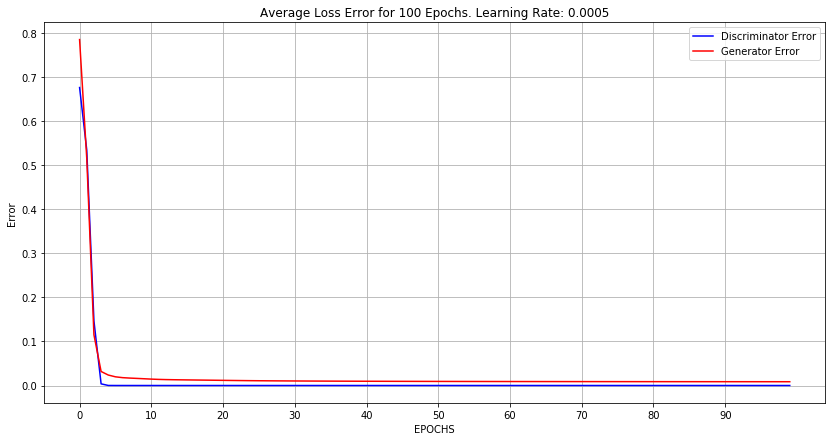

In [22]:
t=np.arange(epochs)
plt.figure(figsize=(14,7))
plt.title('Average Loss Error for {} Epochs. Learning Rate: {}'.format(epochs,lr))
plt.plot(t,Daverageloss,color='b',label='Discriminator Error')
plt.plot(t,Gaverageloss,color='r',label='Generator Error')
plt.xticks(np.arange(0,epochs,10))
plt.xlabel('EPOCHS')
plt.ylabel('Error')
plt.grid(True)
plt.legend()

## Predicted Images (32 x 32) From Low Scale Images(8 X 8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


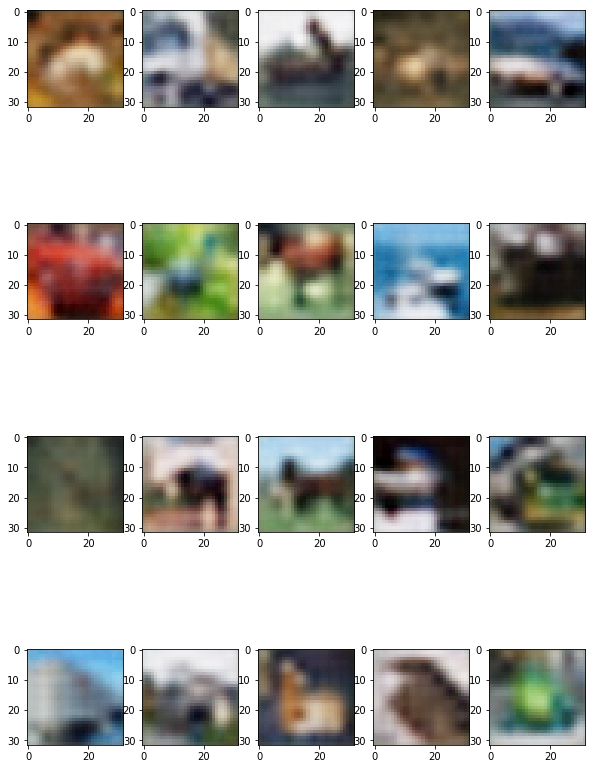

In [23]:
H=np.reshape(samples,(h,32,32,3))
fig=plt.figure(figsize=(10, 15))
columns = 5
rows = 4
for i in range(0, columns*rows ):
    #img = np.random.randint(10, size=(h,w))
    img=H[i]
    fig.add_subplot(rows, columns, (i+1))
    plt.imshow(img)
plt.show()

In [24]:
np.shape(samples)

(10, 20, 32, 32, 3)

## **Original Low Scale Images(8x8) From CIFAR10 dataset**

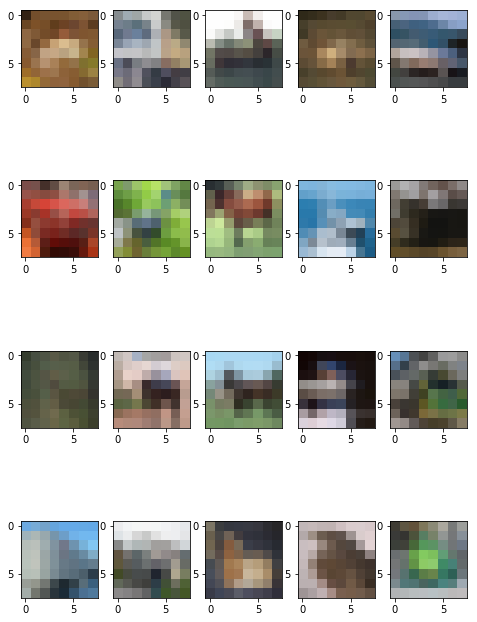

In [25]:
columns = 5
rows = 4
fig=plt.figure(figsize=(8,12))
for i in range(0, columns*rows ):
    #img = np.random.randint(10, size=(h,w))
    img=resized8[i]
    fig.add_subplot(rows, columns, (i+1))
    plt.imshow(img)
plt.show()

## **Original  Images( 32 x 32) From CIFAR10 dataset**

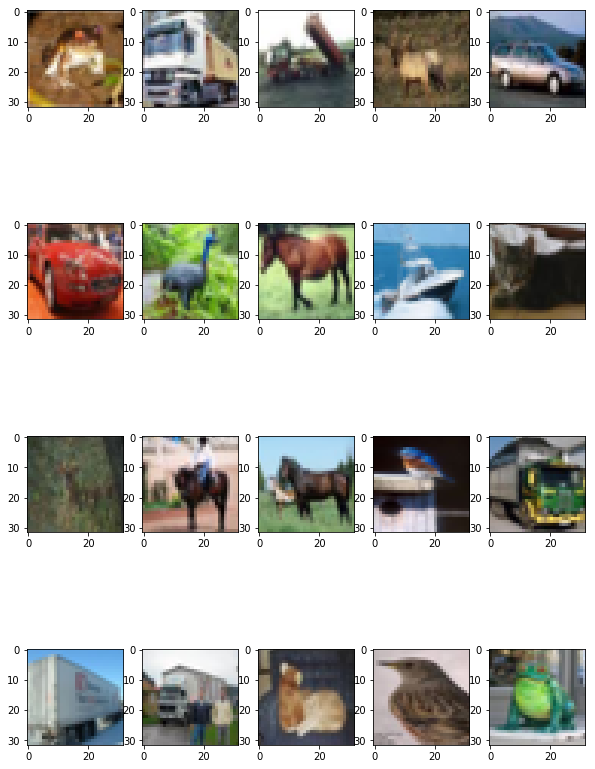

In [26]:
columns = 5
rows = 4
fig=plt.figure(figsize=(10,15))
for i in range(0, columns*rows ):
    #img = np.random.randint(10, size=(h,w))
    img=images[i]
    fig.add_subplot(rows, columns, (i+1))
    plt.imshow(img)
plt.show()

In [27]:
'''
H=np.reshape(samples,(batch_size*num_batches,32,32,3))     
y = images[:50]
y_ = H[:50]

con = tf.confusion_matrix(labels=y_, predictions=y )
sess = tf.Session()
with sess.as_default():
        print(sess.run(con))
'''

'\nH=np.reshape(samples,(batch_size*num_batches,32,32,3))     \ny = images[:50]\ny_ = H[:50]\n\ncon = tf.confusion_matrix(labels=y_, predictions=y )\nsess = tf.Session()\nwith sess.as_default():\n        print(sess.run(con))\n'